# pre-processing and load data

In [1]:
import pandas as pd
import numpy as np
import sklearn
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras.datasets import cifar100

In [2]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
import time

In [3]:
# to calculate how long a part past
def calculate_time(start,finish,stmt):
    print("The time consumed by {} is {:.10f} s!".format(stmt,(finish - start)))
    return finish-start

In [4]:
(x_train, y_train), (x_test, y_test) = cifar100.load_data()
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)


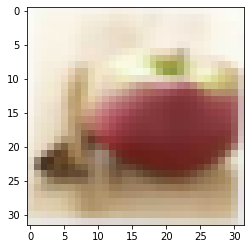

In [5]:
plt.imshow(x_train[2])

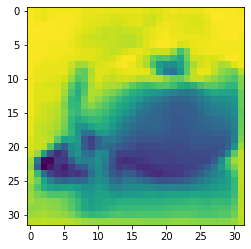

In [6]:
# show one channel
plt.imshow(x_train[2,:,:,0])

In [7]:
# reshape
x_train = x_train.reshape((x_train.shape[0], 32*32*3))
x_test = x_test.reshape((x_test.shape[0], 32*32*3))
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(50000, 3072)
(50000, 1)
(10000, 3072)
(10000, 1)


## Scale data

In [8]:
# =======================================================================================================================
# Scale =================================================================================================================
# =======================================================================================================================

Start = time.perf_counter()
# -----------------------------------------------------------------------------------------------------------------------


scale = MinMaxScaler()
scale.fit(x_train)
x_test = scale.transform(x_test)
x_train = scale.transform(x_train)

# -----------------------------------------------------------------------------------------------------------------------
Finish = time.perf_counter()
timeSCALE = calculate_time(Start,Finish,"fit scale")

The time consumed by fit scale is 1.4733141000 s!


## PCA

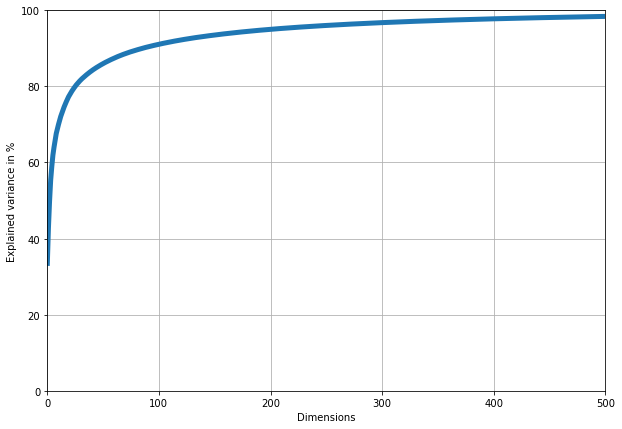

In [9]:
# show PCA in line chart
pca = PCA().fit(x_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
plt.figure(figsize = (10,7))
plt.plot(cumsum*100, linewidth=5)
plt.axis([0, 500, 0, 100]) 
plt.xlabel("Dimensions")
plt.ylabel("Explained variance in %")
plt.grid()
plt.show()



In [10]:
# =======================================================================================================================
# PCA ===================================================================================================================
# =======================================================================================================================

# reduce dimensions to retain 80% of variance
Start = time.perf_counter()
# -----------------------------------------------------------------------------------------------------------------------

pca=PCA(n_components=0.8)
x_train = pca.fit_transform(x_train)
x_test = pca.transform(x_test)

# -----------------------------------------------------------------------------------------------------------------------
Finish = time.perf_counter()
timePCA = calculate_time(Start,Finish,"fit PCA")


The time consumed by fit PCA is 73.3730231000 s!


In [11]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(50000, 26)
(50000, 1)
(10000, 26)
(10000, 1)


# Tuning estimators' hyper - parameters

In [10]:
# Use n_job = 6 to apply Parallelization
from sklearn.model_selection import GridSearchCV

def get_eval(model, para):
    
    grid = GridSearchCV(model, para, cv=5,
                          return_train_score=True, n_jobs= 6,verbose=2)
    grid.fit(x_train, y_train.ravel())
    
    return grid

In [11]:
# print short evaluation
def print_eval(final_model):
    
    print("Training set accuracy: {:.2f}\n".format(final_model.score(x_train, y_train.ravel())))
    print("The Best cross-validation : {}, score: {:.2f}".format(final_model.best_estimator_, final_model.best_score_))

In [15]:
# =======================================================================================================================
# Tuning KNN ============================================================================================================
# =======================================================================================================================

Start = time.perf_counter()
# -----------------------------------------------------------------------------------------------------------------------

from sklearn.neighbors import KNeighborsClassifier

parameters_knn = {'n_neighbors': [5,10,15,20,25,30,35]}
knn = get_eval(KNeighborsClassifier(), parameters_knn)
print_eval(knn)

# -----------------------------------------------------------------------------------------------------------------------
Finish = time.perf_counter()
timeTuningKNN = calculate_time(Start,Finish,"TuningKNN")

Fitting 5 folds for each of 7 candidates, totalling 35 fits
Training set accuracy: 0.25

The Best cross-validation : KNeighborsClassifier(n_neighbors=30), score: 0.17
The time consumed by TuningKNN is 472.2709071000 s!


In [16]:
# =======================================================================================================================
# Tuning SVM ============================================================================================================
# =======================================================================================================================

Start = time.perf_counter()
# -----------------------------------------------------------------------------------------------------------------------

from sklearn.svm import SVC

parameters_svm = {'kernel' : ["rbf"], "C" : [5,10,15],"gamma":[0.001,0.01,0.1]}
SVM_GAUSSIAN = get_eval(SVC(),parameters_svm)
print_eval(SVM_GAUSSIAN)

# -----------------------------------------------------------------------------------------------------------------------
Finish = time.perf_counter()
timeTuningSVM = calculate_time(Start,Finish,"TuningSVM")

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Training set accuracy: 0.76

The Best cross-validation : SVC(C=5, gamma=0.01), score: 0.25
The time consumed by TuningSVM is 5167.9907496000 s!


## Evaluation

In [13]:
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

In [15]:
Start = time.perf_counter()
# -----------------------------------------------------------------------------------------------------------------------
knn_model =  KNeighborsClassifier(n_neighbors=30).fit(x_train,y_train.ravel())
# -----------------------------------------------------------------------------------------------------------------------
Finish = time.perf_counter()
timefittingKNN = calculate_time(Start,Finish,"fitting KNN")

The time consumed by fit KNN is 0.2038899000 s!


In [14]:
Start = time.perf_counter()
# -----------------------------------------------------------------------------------------------------------------------
svm_model = SVC(C=5, gamma=0.01).fit(x_train,y_train.ravel())
# -----------------------------------------------------------------------------------------------------------------------
Finish = time.perf_counter()
timefittingSVM = calculate_time(Start,Finish,"fitting SVM")

The time consumed by fitting SVM is 128.3166487000 s!


In [82]:
eval_knn = classification_report(y_test.ravel(), knn_model.predict(x_test),output_dict = True)

In [93]:
eval_svm = classification_report(y_test.ravel(), svm_model.predict(x_test),output_dict = True)

In [95]:
print("KNN version evaluation: ")
print("\nAccuracy: " + str(eval_knn["accuracy"]))
print("\nPrecision: "+ str(eval_knn["macro avg"]["precision"]))
print("\nRecall: "+ str(eval_knn["macro avg"]["recall"]))

KNN version evaluation: 

Accuracy: 0.1839

Precision: 0.20468359364468694

Recall: 0.18389999999999998


In [96]:
print("SVM version evaluation: ")
print("\nAccuracy: " + str(eval_svm["accuracy"]))
print("\nPrecision: "+ str(eval_svm["macro avg"]["precision"]))
print("\nRecall: "+ str(eval_svm["macro avg"]["recall"]))

SVM version evaluation: 

Accuracy: 0.2659

Precision: 0.2636055170633384

Recall: 0.26589999999999997


In [38]:
from sklearn.metrics import confusion_matrix

cm_knn = confusion_matrix(y_test.ravel(), knn_model.predict(x_test))
cm_svm = confusion_matrix(y_test.ravel(), svm_model.predict(x_test))

Text(0, 0.5, 'True labels')

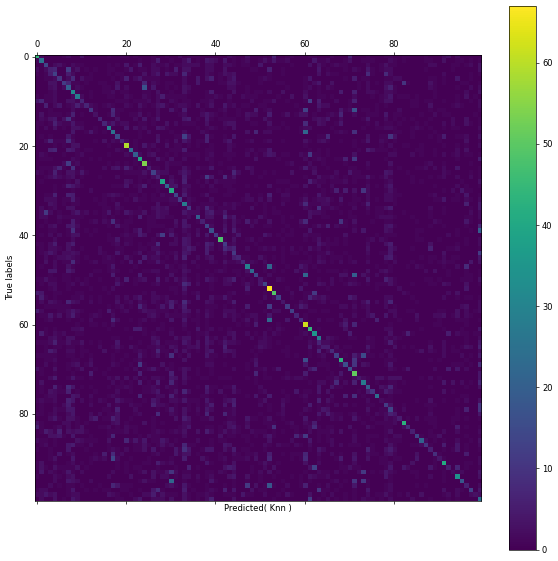

In [66]:
fig = plt.figure(figsize=(12, 12),dpi = 60)
plt.matshow(cm_knn,fignum=0)
plt.colorbar()
plt.xlabel('Predicted( Knn )')
plt.ylabel('True labels')

Text(0, 0.5, 'True labels')

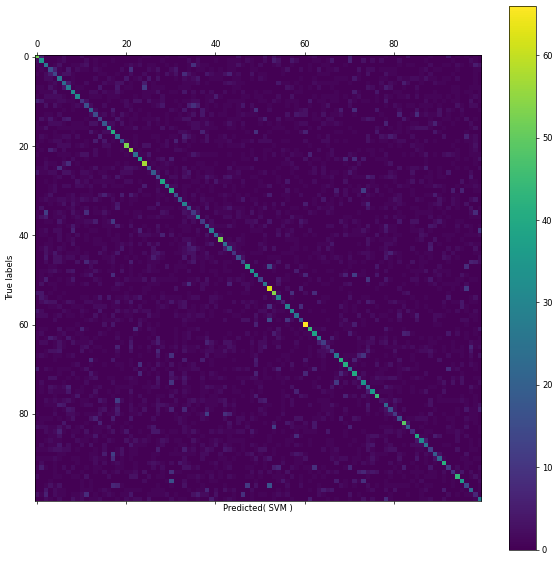

In [64]:
fig = plt.figure(figsize=(12, 12),dpi = 60)
plt.matshow(cm_svm,fignum=0)
plt.colorbar()
plt.xlabel('Predicted( SVM )')
plt.ylabel('True labels')